In [0]:
import numpy as np
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Input, Dense, Activation, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, ZeroPadding2D


In [0]:
(train_x, train_y), (test_x, test_y) = keras.datasets.mnist.load_data()

train_x = train_x.reshape(60000, 28, 28, 1)
test_x = test_x.reshape(10000, 28, 28, 1)
train_x = train_x.astype('float32')/255
test_x = test_x.astype('float32')/255

z_dim = 100
width = 28
height = 28
channels = 1
img_shape = (width, height, channels)

In [0]:
# Generator
adam = Adam(lr=0.0002, beta_1=0.5)

generator = keras.Sequential(
[
    Dense(128 * 7 * 7, activation = 'relu', input_dim = z_dim),
    Reshape((7, 7, 128)),
    UpSampling2D(),
    Conv2D(128, kernel_size = 3, padding = 'same', activation = 'relu'),
    BatchNormalization(),
    UpSampling2D(),
    Conv2D(64, kernel_size = 3, padding = 'same', activation = 'relu'),
    BatchNormalization(),
    Conv2D(1, kernel_size = 3, padding = 'same', activation = 'tanh')
])

# Discriminator
discriminator = keras.Sequential(
[
    Conv2D(32, kernel_size = 3, strides = 2, input_shape = img_shape, padding = 'same'),
    LeakyReLU(alpha = 0.2),
    Conv2D(64, kernel_size = 3, strides = 2, padding = 'same'),
    BatchNormalization(momentum = 0.8),
    LeakyReLU(alpha = 0.2),
    Conv2D(128, kernel_size = 3, strides = 2, padding = 'same'),
    BatchNormalization(momentum = 0.8),
    LeakyReLU(alpha = 0.2),
    Conv2D(256, kernel_size = 3, strides = 1, padding = 'same'),
    BatchNormalization(momentum = 0.8),
    LeakyReLU(alpha = 0.2),
    Flatten(),
    Dense(1, activation = 'sigmoid')
])

generator.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
discriminator.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])

discriminator.trainable = False

inputs = Input(shape = (z_dim,))
hidden = generator(inputs)
output = discriminator(hidden)
gan = keras.Model(inputs, output)
gan.compile(loss = 'binary_crossentropy', optimizer = adam)

In [0]:
def plot_generated(n_ex = 5, dim = (1, 5), figsize = (12, 2)):
    noise = np.random.normal(0, 1, size = (n_ex, z_dim))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(generated_images.shape[0], width, height)
    plt.figure(figsize = figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i, :, :], interpolation = 'nearest', cmap = 'gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [0]:
def train(epochs = 20000, plt_frq = 5000, batch_size = 128):
    print('Epochs:', epochs)
    print('Batch size:', batch_size)
    
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for e in range(1, epochs + 1):
        if e == 1 or e%plt_frq == 0:
            print('-----------', 'Epoch %d' % e, '-----------')
        
        idx = np.random.randint(0, train_x.shape[0], batch_size)
        imgs = train_x[idx]

        # Sample noise and generate a batch of new images
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)

        # Train the discriminator
        discriminator.trainable = True
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, valid)
        
        
        # Update the plots
        if e == 1 or e%plt_frq == 0:
            print('%d [D loss: %f, acc.: %.2f%%] [G loss: %f]' % (e, d_loss[0], 100*d_loss[1], g_loss))
            plot_generated()


Epochs: 20000
Batch size: 128
----------- Epoch 1 -----------
1 [D loss: 1.233806, acc.: 44.14%] [G loss: 0.549929]


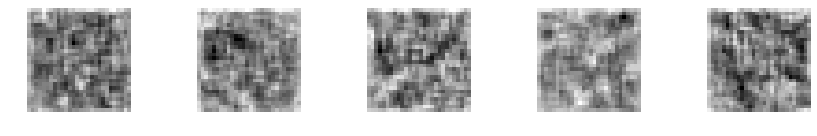

----------- Epoch 5000 -----------
5000 [D loss: 0.001721, acc.: 100.00%] [G loss: 15.814822]


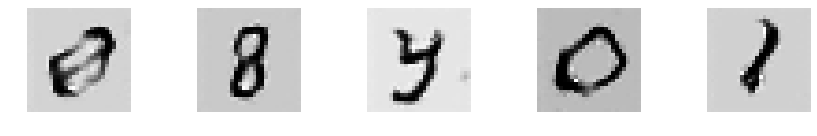

----------- Epoch 10000 -----------
10000 [D loss: 0.023577, acc.: 99.61%] [G loss: 7.970037]


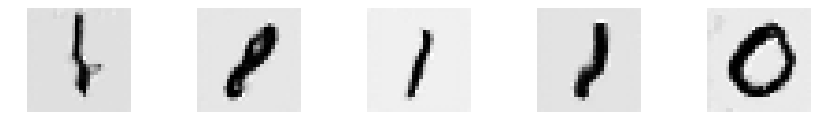

----------- Epoch 15000 -----------
15000 [D loss: 0.009075, acc.: 100.00%] [G loss: 8.118081]


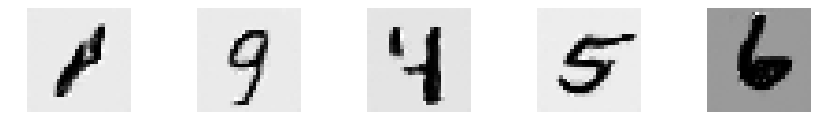

----------- Epoch 20000 -----------
20000 [D loss: 0.026177, acc.: 100.00%] [G loss: 5.616889]


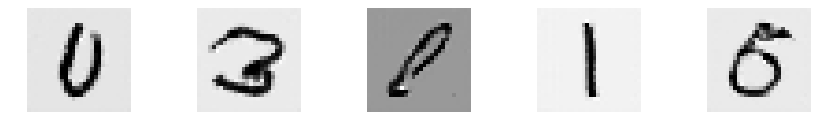

In [6]:
train()